# Introduction

Understanding the behavior of neural networks and why they generalize has been a central pursuit of the theoretical deep learning community.
Our paper [*A Fine-Grained Spectral Perspective on Neural Networks*](https://arxiv.org/abs/1907.10599) attacks this problem by looking at eigenvalues and eigenfunctions, as the name suggests.
We will study the spectra of the *Conjugate Kernel* [[Daniely et al. 2017](http://papers.nips.cc/paper/6427-toward-deeper-understanding-of-neural-networks-the-power-of-initialization-and-a-dual-view-on-expressivity.pdf)], or CK (also called the *Neural Network-Gaussian Process Kernel* [[Lee et al. 2018](http://arxiv.org/abs/1711.00165)]), and the *Neural Tangent Kernel*, or NTK [[Jacot et al. 2018](http://arxiv.org/abs/1806.07572)].
Roughly, the CK and the NTK tell us respectively "what a network looks like at initialization" and "what a network looks like during and after training."
Their spectra then encode valuable information about the initial distribution and the training and generalization properties of neural networks.

## Intuition for the utility of the spectral perspective

Let's take the example of the CK.
We know from [Lee et al. (2018)](http://arxiv.org/abs/1711.00165) that a randomly initialized network is distributed as a Gaussian process $\mathcal N(0, K)$, where $K$ is the corresponding CK, in the infinite-width limit.
If we have the eigendecomposition 
\begin{equation}
K = \sum_{i \ge 1} \lambda_i u_i\otimes u_i
\label{eqn:eigendecomposition}
\end{equation}
with eigenvalues $\lambda_i$ in decreasing order and corresponding eigenfunctions $u_i$, then each sample from this GP can be obtained as 
$$
\sum_{i \ge 1} \sqrt{\lambda_i} \omega_i u_i,\quad
\omega_i \sim \mathcal N(0, 1).
$$
Training the last layer of a randomly initialized network via full batch gradient descent for an infinite amount of time corresponds to Gaussian process inference with kernel $K$ [[Lee et al. 2018](http://arxiv.org/abs/1711.00165), [2019](http://arxiv.org/abs/1902.06720)].
Thus, the more the GP prior (governed by the CK) is consistent with the ground truth function $f^*$, the more we expect the Gaussian process inference and GD training to generalize well.
We can measure this consistency in the "alignment" between the eigenvalues $\lambda_i$ and the squared coefficients $a_i^2$ of $f^*$'s expansion in the $\{u_i\}_i$ basis.
The former can be interpreted as the expected magnitude (squared) of the $u_i$-component of a sample $f \sim \mathcal N(0, K)$, and the latter can be interpreted as the actual magnitude squared of such component of $f^*$.
Here and in this paper, we will investigate an even cleaner setting where $f^* = u_i$ is an eigenfunction.
Thus we would hope to use a kernel whose $i$th eigenvalue $\lambda_i$ is as large as possible.

A similar intuition holds for NTK, because training all parameters of the network for an infinite amount of time yields the mean prediction of the GP $\mathcal N(0, \text{NTK})$ in expectation [[Lee et al. 2019](http://arxiv.org/abs/1902.06720)].

## A brief summary of the spectral theory of CK and NTK

Now, if the CK and the NTK have spectra difficult to compute, then this perspective is not so useful.
But in idealized settings, where the data distribution is uniform over the boolean cube, the sphere, or from the standard Gaussian, a complete (or almost complete in the Gaussian case) eigendecomposition of the kernel can be obtained, thanks to the symmetry of the domain.
Here and in the paper, we focus on the boolean cube, since in high dimensions, all three distributions are very similar, and the boolean cube eigenvalues are much easier to compute (see paper for more details).

We briefly summarize the spectral theory of CK and NTK (of multilayer perceptrons, or MLPs) on the boolean cube.
First, these kernels are always diagonalized by the *boolean Fourier basis*, which are just monomial functions like $x_1 x_3 x_{10}$.
These Fourier basis functions are naturally graded by their *degree*, ranging from 0 to the dimension $d$ of the cube.
Then the kernel has $d+1$ unique eigenvalues,
$$\mu_0, \ldots, \mu_d$$
corresponding to each of the degrees, so that the eigenspace associated to $\mu_k$ is a $\binom d k$ dimensional space of monomials with degree $k$.
These eigenvalues are simple linear functions of a small number of the kernel values, and can be easily computed.

Let's try computing them ourselves!

# Computing Eigenvalues over a Grid of Hyperparameters

In [1]:
import numpy as np
import scipy as sp
from scipy.special import erf as erf
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
sns.set()
from mpl_toolkits.axes_grid1 import ImageGrid
def tight_layout(plt):
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Our methods for doing the theoretical computations lie in the `theory` module.

In [2]:
from theory import *

First, let's compute the eigenvalues of erf CK and NTK over a large range of hyperparameters:

- $\sigma_w^2 \in [1, 5]$
- $\sigma_b^2 \in [0, 4]$
- dimension 128 boolean cube
- depth up to 128
- degree $k \le 8$.

Unless stated otherwise, all plots below use these hyperparameters.

We will do the same for relu kernels later.

In [3]:
# range of $\sigma_b^2$
erfvbrange = np.linspace(0, 4, num=41)
# range of $\sigma_w^2$
erfvwrange = np.linspace(1, 5, num=41)
erfvws, erfvbs = np.meshgrid(erfvwrange, erfvbrange, indexing='ij')
# `dim` = $d$
dim = 128
depth = 128
# we will compute the eigenvalues $\mu_k$ for $k = 0, 1, ..., maxdeg$.
maxdeg = 8

As mentioned in the paper, any CK or NTK $K$ of multilayer perceptrons (MLPs) takes the form
$$K(x, y) = \Phi\left(\frac{\langle x, y \rangle}{\|x\|\|y\|}, \frac{\|x\|^2}d, \frac{\|y\|^2}d\right)$$
for some function $\Phi: \mathbb R^3 \to \mathbb R$.
On the boolean cube $\{1, -1\}^d$, $\|x\|^2 = d$ for all $x$, and $\langle x, y \rangle / d$ takes value in a discrete set $\{-1, -1+2/d, \ldots, 1-2/d, 1\}$.
Thus $K(x, y)$ only takes a finite number of different values as well.
We first compute these values (see paper for the precise formulas).

In [4]:
# `erfkervals` has two entries, with keys `cks` and `ntks`.
# Each entry is an array with shape (`depth`, len(erfvwrange), len(erfvbrange), `dim`+1)
# The last dimension carries the entries $\Phi(-1), \Phi(-1 + 2/d), ..., \Phi(1)$
erfkervals = boolcubeFgrid(dim, depth, erfvws, erfvbs, VErf, VDerErf)

In [5]:
erfkervals['cks'].shape

(129, 41, 41, 129)

The eigenvalues $\mu_k, k = 0, 1, \ldots, d$, can be expressed as a simple linear function of $\Phi$'s values, as hinted before.
However, a naive evaluation would lose too much numerical precision because the number of alternating terms.
Instead, we do something more clever, resulting in the following algorithm:

- For $\Delta = 2/d$, we first evaluate $\Phi^{(a)}(x) = \frac 1 2 \left(\Phi^{(a-1)}(x) - \Phi^{(a-1)}(x - \Delta)\right)$ with base case $\Phi^{(0)} = \Phi$, for $a = 0, 1, \ldots$, and for various values of $x$.
- Then we just sum a bunch of nonnegative terms to get the eigenvalue $\mu_k$ associated to degree $k$ monomials
$$\mu_k = \frac 1{2^{d-k}} \sum_{r=0}^{d-k}\binom{d-k}r \Phi^{(k)}(1 - r \Delta).$$

We will actually use an even more clever algorithm here, but with the same line of the reasoning; see the paper and the `twostep` option in the source code for details.

Note that, here we will compute *normalized eigenvalues*, normalized by their trace.
So these normalized eigenvalues, with multiplicity, should sum up to 1.

In [6]:
erfeigs = {}
# `erfeigs['ck']` is an array with shape (`maxdeg`, `depth`+1, len(erfvwrange), len(erfvbrange))
# `erfeigs['ck'][k, L] is the matrix of eigenvalue $\mu_k$ for a depth $L$ erf network,
# as a function of the values of $\sigma_w^2, \sigma_b^2$ in `erfvwrange` and `erfvbrange`
# Note that these eigenvalues are normalized by the trace
# (so that all normalized eigenvalues sum up to 1)
erfeigs['ck'] = relu(boolCubeMuAll(dim, maxdeg, erfkervals['cks']))
# similarly for `erfeigs['ntk']`
erfeigs['ntk'] = relu(boolCubeMuAll(dim, maxdeg, erfkervals['ntks']))

To perform fine-grained analysis of how hyperparameters affects the performance of the kernel and thus the network itself, we use a heuristic, the *fractional variance*, defined as
$$
\text{degree $k$ fractional variance} = \frac{\binom d k \mu_k}{\sum_{i=0}^d \binom d i \mu_i}.
$$
This terminology comes from the fact that, if we were to sample a function $f$ from a Gaussian process with kernel $K$, then we expect that $r\%$ of the total variance of $f$ comes from degree $k$ components of $f$, where $r\%$ is the degree $k$ fractional variance.
If we were to try to learn a homogeneous degree-$k$ polynomial using a kernel $K$, intuitively we should try to choose $K$ such that its $\mu_k$ is maximized.
In the paper, we present empirical evidence that fractional variance is indeed inversely correlated with test loss.

So let's compute them.

In [7]:
# `erfeigs['ckfracvar']` is an array with shape (`maxdeg`, `depth`+1, len(erfvwrange), len(erfvbrange))
# just like `erfeigs['ck']`
erfeigs['ckfracvar'] = (
    sp.special.binom(dim, np.arange(0, maxdeg+1))[:, None, None, None]
    * erfeigs['ck']
)
# Same thing here
erfeigs['ntkfracvar'] = (
    sp.special.binom(dim, np.arange(0, maxdeg+1))[:, None, None, None]
    * erfeigs['ntk']
)

In [8]:
erfeigs['ckfracvar'].shape

(9, 129, 41, 41)

Similarly, let's compute the eigenvalues of ReLU CK and NTK over a large range of hyperparameters:

- $\sigma_w^2 = 2$
- $\sigma_b^2 \in [0, 4]$
- dimension 128 boolean cube
- depth up to 128
- degree $k \le 8$.

Unless stated otherwise, all plots below use these hyperparameters.

In [9]:
reluvws, reluvbs = np.meshgrid([2], np.linspace(0, 4, num=401), indexing='ij')
dim = 128
depth = 128
maxdeg = 8

relukervals = boolcubeFgrid(dim, depth, reluvws, reluvbs, VReLU, VStep)

relueigs = {}
relueigs['ck'] = relu(boolCubeMuAll(dim, maxdeg, relukervals['cks']))
relueigs['ntk'] = relu(boolCubeMuAll(dim, maxdeg, relukervals['ntks']))
relueigs['ckfracvar'] = (
    sp.special.binom(dim, np.arange(0, maxdeg+1))[:, None, None, None]
    * relueigs['ck']
)
relueigs['ntkfracvar'] = (
    sp.special.binom(dim, np.arange(0, maxdeg+1))[:, None, None, None]
    * relueigs['ntk']
)

Now we have computed all the eigenvalues, let's take a look at them!

# Deeper Networks Learn More Complex Features --- But Not Too Deep

If $K$ were to be the CK or NTK of a relu or erf MLP, then we find that for higher $k$, depth of the network helps increase $\mu_k$.

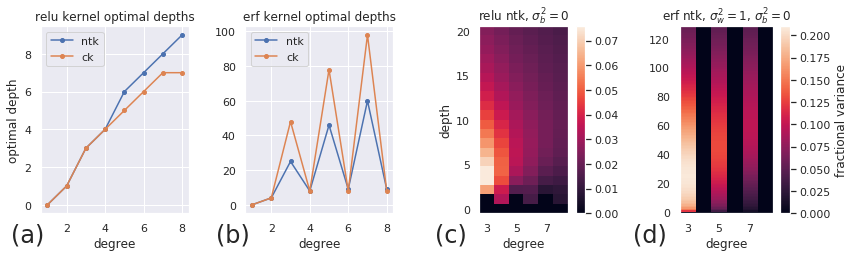

In [10]:
maxdeg = 8
plt.figure(figsize=(12, 4))

relueigs['ntkbestdepth'] = np.argmax(np.max(relueigs['ntk'][1:, :, ...], axis=(2, 3)), axis=1).squeeze()
relueigs['ckbestdepth'] = np.argmax(np.max(relueigs['ck'][1:, :, ...], axis=(2, 3)), axis=1).squeeze()
fig = plt.subplot(141)
plt.text(-.2, -.15, '(a)', fontsize=24, transform=fig.axes.transAxes)
plt.plot(np.arange(1, maxdeg+1), relueigs['ntkbestdepth'], label='ntk', markersize=4, marker='o')
plt.plot(np.arange(1, maxdeg+1), relueigs['ckbestdepth'], label='ck', markersize=4, marker='o')
plt.legend()
plt.xlabel('degree')
plt.ylabel('optimal depth')
plt.title('relu kernel optimal depths')

erfeigs['ntkbestdepth'] = np.argmax(np.max(erfeigs['ntk'][1:, :, ...], axis=(2, 3)), axis=1).squeeze()
erfeigs['ckbestdepth'] = np.argmax(np.max(erfeigs['ck'][1:, :, ...], axis=(2, 3)), axis=1).squeeze()
fig = plt.subplot(142)
plt.text(-.2, -.15, '(b)', fontsize=24, transform=fig.axes.transAxes)
plt.plot(np.arange(1, maxdeg+1), erfeigs['ntkbestdepth'], label='ntk', markersize=4, marker='o')
plt.plot(np.arange(1, maxdeg+1), erfeigs['ckbestdepth'], label='ck', markersize=4, marker='o')
plt.legend()
plt.xlabel('degree')
plt.title('erf kernel optimal depths')

fig = plt.subplot(143)
plt.text(-.5, -.15, '(c)', fontsize=24, transform=fig.axes.transAxes)
plt.imshow(relueigs['ntkfracvar'][3:, :20, 0, 0].T, aspect=12/20, origin='lower', extent=[2.5, 8.5, -.5, 20.5])
cb = plt.colorbar()
plt.xticks(range(3, 9, 2))
plt.xlabel('degree')
plt.ylabel('depth')
plt.grid()
plt.title(u'relu ntk, $\sigma_b^2=0$')

fig = plt.subplot(144)
plt.text(-.5, -.15, '(d)', fontsize=24, transform=fig.axes.transAxes)
plt.imshow(erfeigs['ntkfracvar'][3:, :, 0, 0].T, aspect=12/129, origin='lower', extent=[2.5, 8.5, -.5, 128.5], vmin=0, vmax=0.21)
cb = plt.colorbar()
cb.set_label('fractional variance')
plt.xticks(range(3, 9, 2))
plt.xlabel('degree')
plt.grid()
plt.title(u'erf ntk, $\sigma_w^2=1$, $\sigma_b^2=0$')



tight_layout(plt)

In **(a)** and **(b)** above, we plot, for each degree $k$, the depth that (with some combination of other hyperparameters like $\sigma_b^2$) maximizes degree $k$ fractional variance, for respectively relu and erf kernels.
Clearly, the maximizing depths are increasing with $k$ for relu, and also for erf when considering either odd $k$ or even $k$ only.
The slightly differing behavior between even and odd $k$ is expected, as seen in the form of Theorem 4.1 in the paper.
Note the different scales of y-axes for relu and erf --- the depth effect is much stronger for erf than relu.

For relu NTK and CK, $\sigma_b^2=0$ maximizes fractional variance in general, and the same holds for erf NTK and CK in the odd degrees (see our other notebook, [TheCompleteHyperparameterPicture]()).
In **(c)** and **(d)**, we give a more fine-grained look at the $\sigma_b^2=0$ slice, via heatmaps of fractional variance against degree and depth.
Brighter color indicates higher variance, and we see the optimal depth for each degree $k$ clearly increases with $k$ for relu NTK, and likewise for odd degrees of erf NTK.
However, note that as $k$ increases, the difference between the maximal fractional variance and those slightly suboptimal becomes smaller and smaller, reflected by suppressed range of color moving to the right.
The heatmaps for relu and erf CKs look similar (compute them yourself, as an exercise!).

In the paper, this trend of increasing optimal depth is backed up empirical data from training neural networks to learn polynomials of various degrees.

Note that implicit in our results here is a highly nontrivial observation:
Past some point (the *optimal depth*), high depth can be detrimental to the performance of the network, beyond just the difficulty to train, and this detriment can already be seen in the corresponding NTK or CK.
In particular, it's *not* true that the optimal depth is infinite.
This adds significant nuance to the folk wisdom that "depth increases expressivity and allows neural networks to learn more complex features."

# NTK Favors More Complex Features Than CK

We generally find the degree $k$ fractional variance of NTK to be higher than that of CK when $k$ is large, and vice versa when $k$ is small.

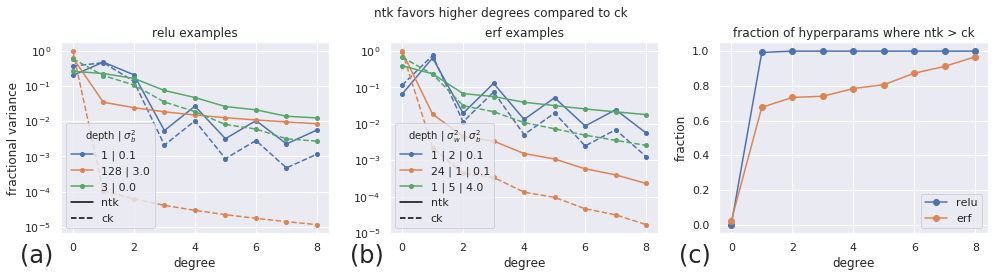

In [11]:
plt.figure(figsize=(14, 4))
def convert2vb(i):
    return i/100

fig = plt.subplot(131)
plt.text(-.15, -.15, '(a)', fontsize=24, transform=fig.axes.transAxes)
cpal = sns.color_palette()
for i, (depth, vbid) in enumerate([(1, 10), (128, 300), (3, 0)]):
    color = cpal[i]
    plt.plot(relueigs['ntkfracvar'][:, depth, 0, vbid], c=color, label='{} | {}'.format(depth, convert2vb(vbid)), marker='o', markersize=4)
    plt.plot(relueigs['ckfracvar'][:, depth, 0, vbid], '--', c=color, marker='o', markersize=4)
plt.plot([], c='black', label='ntk')
plt.plot([], '--', c='black', label='ck')
plt.legend(title=u'depth | $\sigma_b^2$')
plt.xlabel('degree')
plt.ylabel('fractional variance')
plt.title('relu examples')
plt.semilogy()

def convert2vb(i):
    return i/10
def convert2vw(i):
    return i/10 + 1
cpal = sns.color_palette()
fig = plt.subplot(132)
plt.text(-.15, -.15, '(b)', fontsize=24, transform=fig.axes.transAxes)
for i, (depth, vwid, vbid) in enumerate([(1, 10, 1),(24, 0, 1), (1, 40, 40)]):
    color = cpal[i]
    plt.plot(erfeigs['ntkfracvar'][:, depth, vwid, vbid], c=color,
             label='{} | {} | {}'.format(depth, int(convert2vw(vwid)), convert2vb(vbid)), marker='o', markersize=4)
    plt.plot(erfeigs['ckfracvar'][:, depth, vwid, vbid], '--', c=color, marker='o', markersize=4)
plt.plot([], c='black', label='ntk')
plt.plot([], '--', c='black', label='ck')
plt.legend(title=u'depth | $\sigma_w^2$ | $\sigma_b^2$')
plt.xlabel('degree')
plt.title('erf examples')
plt.semilogy()

fig = plt.subplot(133)
plt.text(-.15, -.15, '(c)', fontsize=24, transform=fig.axes.transAxes)
# relu
balance = np.mean((relueigs['ntk'] > relueigs['ck']) & (relueigs['ntk'] > 1e-15), axis=(1, 2, 3))
# needed to filter out all situations where eigenval is so small that it's likely just 0
balance /= np.mean((relueigs['ntk'] > 1e-15), axis=(1, 2, 3))
plt.plot(np.arange(0, maxdeg+1), balance, marker='o', label='relu')
# erf
balance = np.mean((erfeigs['ntk'] > erfeigs['ck']) & (erfeigs['ntk'] > 1e-15), axis=(1, 2, 3))
# needed to filter out all situations where eigenval is so small that it's likely just 0
balance /= np.mean((erfeigs['ntk'] > 1e-15), axis=(1, 2, 3))
plt.plot(np.arange(0, maxdeg+1), balance, marker='o', label='erf')

plt.xlabel('degree')
plt.ylabel('fraction')
plt.legend()
plt.title('fraction of hyperparams where ntk > ck')

plt.suptitle('ntk favors higher degrees compared to ck')
tight_layout(plt)

In **(a)**, we give several examples of the fractional variance curves for relu CK and NTK across several representative hyperparameters.
In **(b)**, we do the same for erf CK and NTK.
In both cases, we clearly see that, while for degree 0 or 1, the fractional variance is typically higher for CK, the reverse is true for larger degrees.
In **(c)**, for each degree $k$, we plot the *fraction of hyperparameters* where the degree $k$ fractional variance of NTK is greater than that of CK.
Consistent with previous observations, this fraction increases with the degree.

This means that, if we train only the last layer of a neural network (i.e. CK dynamics), we intuitively should expect to learn *simpler* features faster and generalize better, while, if we train all parameters of the network (i.e. NTK dynamics), we should expect to learn more *complex* features faster and generalize better.
Similarly, if we were to sample a function from a Gaussian process with the CK as kernel (recall this is just the distribution of randomly initialized infinite width MLPs), this function is more likely to be accurately approximated by low degree polynomials than the same with the NTK.

Again, in the paper, we present empirical evidence that, training the last layer is better than training all layers only for degree 0 polynomials, i.e. constant functions, but is worse for all higher degree (homogenous) polynomials.
This corroborates the observations made from the spectra here.

# Conclusion

We have replicated the spectral plots of section 5 and 6 in the paper, concerning the generalization properties of neural networks.
As one can see, the spectral perspective is quite useful for understanding the effects of hyperparameters.
A complete picture of how the combination of $\sigma_w^2, \sigma_b^2$, depth, degree, and nonlinearity affects fractional variance is presented in the notebook *[The Complete Hyperparameter Picture](TheCompleteHyperparameterPicture.ipynb)*.
The fractional variance is, however, by no means a perfect indicator of generalization, and there's plenty of room for improvement, as mentioned in the main text.
We hope a better predictor of test loss can be obtained in future works.

Another interesting topic that spectral analysis can shed light on is the so-called "simplicity bias" of neural networks.
We discuss this in the notebook *[Clarifying Simplicity Bias](ClarifyingSimplicityBias.ipynb)*.